In [215]:
import numpy as np
import numpy.matlib
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

In [216]:
from keras.datasets import mnist
from sklearn.linear_model import Ridge

In [217]:
def plot_outputs(target, output, test_input=None, output_color='magenta', input_color='yellow', target_color='cyan', error_color='red', facecolor='black', figsize=(20,10)):
    (fig, ax) = plt.subplots(figsize=figsize)
    ax.set_facecolor(facecolor)
    ax.plot(target, color=target_color, linewidth=4)
    ax.plot(output, color=output_color, linewidth=1.5)
    error = np.abs(output - target)
    ax.plot(error, color=error_color)
    if test_input is not None:
        ax.plot(test_input, color=input_color, linestyle='dotted')
    plt.show()

def plot_weight_matrix(w, ax=None, shape=None, figsize=(20,5)):
    if shape is not None:
        w = np.resize(w, shape)
    if ax is None:
        (fig, ax) = plt.subplots(figsize=figsize)
    ax.imshow(w, cmap='gray')
    if ax is None:
        plt.show()

In [218]:
def tanh(x):
    return np.tanh(x).real

3.	Modeling of dynamic systems with ESNs
-------------------------------------------

1. Generate a sequence for 4,000 time steps; n is in the range between 1 and 4,000.

In [219]:
def generateSequence(parameters):
    valueArray = []
    for n in range(parameters[0],parameters[1]+1):
        value = 0.5 * math.sin(n/4)
        valueArray.append(value) 
    return(valueArray)

In [220]:
rangeParameters = [1, 4000] 
dataValues = generateSequence(rangeParameters)
print(len(dataValues))

4000


2. Take the first 3,000 steps for the training and leave the last 1,000 steps for
the testing. 

In [221]:
def splitArrayTwo(array, firstLength):
    firstArray = array[:firstLength]
    secoundArray = array[firstLength:]
    firstArray = np.array(firstArray)
    secoundArray = np.array(secoundArray)
    
    return firstArray, secoundArray

In [222]:
train_Data , test_Data = splitArrayTwo(dataValues, 3000)
print(len(train_Data), len(test_Data))

3000 1000


3. Fix the reservoir size to Nx = 1,000 neurons.

In [223]:
res_size = 1000

4. Generate input weight matrix W_in from uniform distribution between -1 and 1. Scale W_in by 0.2.


In [224]:
scale = 0.2
weight_min = -1
weight_max = 1
weight_in = np.random.uniform(weight_min, weight_max, (res_size, 2)) * scale
weight_res = np.random.uniform(weight_min, weight_max, (res_size, res_size)) * scale

5. Do not forget to add a bias input neuron, which constantly feeds 1 to the reservoir.

In [225]:
bias = 1

6. Set the spectral radius (feedback strength) for the reservoir connection matrix to ρ = 0.8.

In [226]:
p = 0.8

7. Feed-in ground truth-values of the signal to the ESN during the training.

In [227]:
def training(train_set):
    weight_out = np.random.uniform(-1, 1, (1, (res_size+1+1))) * scale
    weight_back = np.random.uniform(-1, 1, (res_size, 1)) * scale

    x = np.zeros(1000)
    y = np.zeros(1)
    reg_X = []
    reg_Y = []

    discard = 1000
    ridge_reg = Ridge()

    for i in range(1, 2998):
        u = np.array([train_set[i], bias])

        in_dot = np.dot(weight_in, u)
        res_dot = np.dot(weight_res, x)
        back_dot = np.dot(weight_back, np.array([train_set[i-1]]).real)

        concatenation = np.concatenate([u, x])

        x = tanh(in_dot + res_dot + back_dot)
        y = np.array(tanh(np.dot(weight_out, concatenation))) #from functions 15 & 16 in the paper as well as the first sentance on page 15

        y_target = np.array([train_set[i+1]]).real
        reg_X.append(concatenation)
        reg_Y.append(y_target)
    
    ridge_reg.fit(reg_X[discard:], reg_Y[discard:])
    weight_out = ridge_reg.coef_

    #plot_weight_matrix(weight_out, shape=[3,167])

    return x, y, weight_out, weight_back

In [228]:
def ESN(test_set, x, y, weight_in, weight_back, weight_out, weight_res):

    for i in range(0, len(test_set)-1):
        u = np.array([test_set[i], bias])

        in_dot = np.dot(weight_in, u)
        res_dot = np.dot(weight_res, x)
        back_dot = np.dot(weight_back, np.array([test_set[i-1]]).real)

        concatenation = np.concatenate([u, x])

        x = tanh(in_dot + res_dot + back_dot)
        y = np.array(tanh(np.dot(weight_out, concatenation))) #from functions 15 & 16 in the paper as well as the first sentance on page 15

        y_target = 0

        return

In [229]:
x, y, weight_out, weight_back = training(train_Data)
ESN(test_Data, x, y, weight_in, weight_back, weight_out, weight_res)

8. For time step n the teaching forcing signal is the value of the signal at time step n+1, i.e., y(n+1).

9. Using the state of reservoirs for the training sequence and the corresponding values of the teaching forcing signal estimate the readout matrix.

10. When estimating the readout matrix discard the first 1,000 steps in the training sequence from the calculation.

11. In the operating phase, the network acts as the generator of the signal (thanks to trained readout matrix) feeding its previous prediction (at time n−1) back to the reservoir

12. At the beginning of the operating phase, initialize the reservoir with the last state for the training sequence. 

13. Make predictions for all 1,000 testing time steps. 

14. Repeat the experiment for 10 different random initializations of ESNs. 


15. Plot the ground truth for the testing sequence versus the predictions obtained for ESN. Summarize 10 independent runs using mean values of predictions.

Given code
-----------


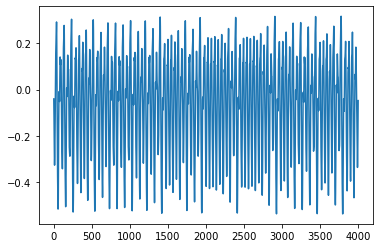

In [230]:

# check for intuition at  http://users.fs.cvut.cz/ivo.bukovsky/PVVR/prace_studentu/Mackey_Glass_time_series_prediction_Fuzzy_Lookup.pdf

def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a) 
)  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements
length=4000 # duration of the series
tau=17 # delay in the equation
y=mackey_glass(tau, length)
#plot generated time-series
plt.plot(y)
plt.show()